In [2]:
import scipy.sparse as ss
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import time
import japanize_matplotlib # pip install japanize-matplotlib
import pyswarms as ps
import math

In [3]:
sigma = 0.2 
gamma = 0.1
migration = 0.1

def SEIR_Single(df, df_flow, beta):
    df_flow = df_flow.apply(lambda x: x/sum(x), axis=1)
    for i in range(len(df_flow)):
        df_flow.iloc[i,i] = 0
    df_out = df_flow.apply(lambda x: sum(x), axis=1)
    df_dec = df.apply(lambda x: (x*df_out), axis=0)
    
    df['N'] = df['S'] + df['E'] + df['I'] + df['R']
    df['Beta'] = beta
    df['S'] = df['S'] + -df['Beta']*df['I']*df['S']/df['N']
    df['E'] = df['E'] + df['Beta']*df['I']*df['S']/df['N'] - sigma*df['E']
    df['I'] = df['I'] + sigma*df['E'] - gamma*df['I']
    df['R'] = df['R'] + gamma * df['I']
    df = df.drop(columns=['N', 'Beta'])
    
    df_inc = pd.DataFrame(np.matmul(df_flow.T.values, df.values), index=TARGET_AREA, columns=['S', 'E', 'I', 'R'])
    df = df + (df_inc - df_dec) * migration
    return df

def SEIR_Multi(beta_list, day_list, df_seir_initial, trans):
    df_seir = df_seir_initial.copy()
    prediction = []
    for i in day_list:
        df_flow = pd.DataFrame(trans[i, :, :], index=TARGET_AREA, columns=TARGET_AREA)
        df_seir = SEIR_Single(df_seir, df_flow, beta_list)
        df_seir_r = df_seir.round().astype(int)
        prediction.append(df_seir_r['I'].tolist())
    return df_seir, np.array(prediction)

def loss(prediction, ground_truth):
    ground_truth = ground_truth.clip(min=1)
    mape_lambda = 300
    return np.mean(np.abs(prediction-ground_truth)) + np.mean(np.abs(prediction-ground_truth)/ground_truth) * mape_lambda

def opt_func(X, day_list, df_seir, trans, infec):
    n_particles = X.shape[0]  # number of particles
    ground_truth = infec[day_list, :]
    dist = []
    for i in range(n_particles):
        _, prediction = SEIR_Multi(X[i, :], day_list, df_seir, trans)
        dist.append(loss(prediction, ground_truth))
    return np.array(dist)

def run_interval_PSO(day_list, df_seir, trans, infec):
    # print('Start Particle Swarm Optimization ...', time.ctime())
    cpu_num = 10
    swarm_size = 50
    iters_num = 100
    beta_low = 0.01
    beta_high = 0.4
    dim = len(TARGET_AREA)  # Dimension of X
    options = {'c1': 0.5, 'c2':0.5, 'w':0.5}
    constraints = (np.array([beta_low] * dim), np.array([beta_high] * dim))
    optimizer = ps.single.GlobalBestPSO(n_particles=swarm_size, dimensions=dim, options=options, bounds=constraints)
    cost, pos = optimizer.optimize(opt_func, iters=iters_num, n_processes=cpu_num, verbose=False, 
                                   day_list=day_list, df_seir=df_seir, trans=trans, infec=infec)
    return cost, pos

def run_all_PSO(trans, infec):
    assert len(trans) == len(infec), 'len(trans) == len(infec) should be equal'
    T_ALL = len(trans)
    df_seir = pd.DataFrame(np.zeros((len(TARGET_AREA), len(['S', 'E', 'I', 'R'])), dtype='int'), index=TARGET_AREA, columns=['S', 'E', 'I', 'R'])
    df_seir['I'] = infec[0, :]
    df_seir['S'] = POPULATION
    day_list_all = np.arange(T_ALL)
    predictions = []
    opt_betas = [] 
    for i in range(math.ceil(T_ALL / T_INTERVAL)):
        day_list = day_list_all[i*T_INTERVAL:(i+1)*T_INTERVAL]
        cost, pos = run_interval_PSO(day_list, df_seir, trans, infec)
        df_seir, prediction = SEIR_Multi(pos, day_list, df_seir, trans)
        print(i, day_list, cost, pos, time.ctime())
        predictions.extend(prediction)
        opt_betas.append(pos)
    predictions = np.array(predictions)
    opt_betas = np.array(opt_betas)
    df_seir.to_csv(BASE + '/{}_lastseir_{}days.csv'.format(NAME, T_INTERVAL), index=True, header=True)
    np.savetxt(BASE + '/{}_predictions_{}days.csv'.format(NAME, T_INTERVAL), predictions, delimiter=',', fmt='%d')
    np.savetxt(BASE + '/{}_betas_{}days.csv'.format(NAME, T_INTERVAL), opt_betas, delimiter=',', fmt='%.8f')
    print('final predictions...', predictions.shape)
    print('final opt_betas...', opt_betas.shape)
    return predictions, opt_betas, df_seir

In [4]:
#################################################################
# POPULATIONPATH = '/nas/Covid-Project-Data/demographic_data/pref_population_2015.csv'
# INFECTIONPATH = '/nas/Covid-Project-Data/groundtruth_infection_curve_data/chuang_acc_infection_num.csv'
# ODPATH = '/data2/cai/OD/japan/aggregate_prov/results/od_day20180101_20210228.npz'
POPULATIONPATH = 'data/pref_population_2015.csv'
INFECTIONPATH = 'data/acc_infection_num.csv'
ODPATH = 'data/od_day20180101_20210228.npz'
OD_DAYS = [date.strftime('%Y-%m-%d') for date in pd.date_range(start='2018-01-01', end='2021-02-28', freq='1D')]
BASE = 'MetaPopulationResult'
TARGET_AREA = ['東京都', '千葉県','神奈川県','埼玉県']
TARGET_AREA_EN = ['Tokyo', 'Chiba', 'Kanagawa', 'Saitama']
NAME = 'kanto4prefecture_metapopulation'

if len(TARGET_AREA) == 0:
    pref_population = pd.read_csv(POPULATIONPATH)
    TARGET_AREA = pref_population['ken'].values
    POPULATION = pref_population['population'].values
    TARGET_AREA_ID = np.arange(POPULATION).tolist()
    print(POPULATION)
    print(TARGET_AREA_ID)
else:
    pref_population = pd.read_csv(POPULATIONPATH)
    pref_population['gid'] -= 1
    pref_population = pref_population[pref_population['ken'].isin(TARGET_AREA)]
    pref_population = pref_population[['ken', 'gid', 'population']]
    pref_population = pref_population.set_index('ken')
    pref_population = pref_population.reindex(index=TARGET_AREA)
    POPULATION = pref_population['population'].values.squeeze()
    TARGET_AREA_ID = pref_population['gid'].values.squeeze().tolist()
    print(POPULATION)
    print(TARGET_AREA_ID)

START_DATE, END_DATE = '2020-01-20', '2021-01-31'
train_infection = pd.read_csv(INFECTIONPATH)
train_infection['Day'] = pd.to_datetime(train_infection['Day'])
train_infection = train_infection[(train_infection['Day']>=START_DATE) & (train_infection['Day']<=END_DATE)]
train_infection = train_infection.reset_index(drop=True)
train_infection = train_infection.drop(columns=['Day'])
train_infection = train_infection[TARGET_AREA]
train_infection = train_infection.values
print(train_infection.shape)

train_trans = ss.load_npz(ODPATH)
train_trans = np.array(train_trans.todense()).reshape((-1, 47, 47))
train_trans = train_trans[OD_DAYS.index(START_DATE):OD_DAYS.index(END_DATE)+1,:,:]
train_trans = train_trans[:, TARGET_AREA_ID, :][:, :, TARGET_AREA_ID]
print(train_trans.shape)

PRED_START_DATE, PRED_END_DATE = '2021-02-01', '2021-02-28' # The last four weeks.
test_infection = pd.read_csv(INFECTIONPATH)
test_infection['Day'] = pd.to_datetime(test_infection['Day'])
test_infection = test_infection[(test_infection['Day']>=PRED_START_DATE) & (test_infection['Day']<=PRED_END_DATE)]
test_infection = test_infection.reset_index(drop=True)
test_infection = test_infection.drop(columns=['Day'])
test_infection = test_infection[TARGET_AREA]
test_infection = test_infection.values
print(test_infection.shape)

test_trans = ss.load_npz(ODPATH)
test_trans = np.array(test_trans.todense()).reshape((-1, 47, 47))
test_trans = test_trans[OD_DAYS.index(PRED_START_DATE):OD_DAYS.index(PRED_END_DATE)+1,:,:]
test_trans = test_trans[:, TARGET_AREA_ID, :][:, :, TARGET_AREA_ID]
print(test_trans.shape)

T_INTERVAL = 7
###################################################################

2021-06-28 10:08:38,081 - numexpr.utils - INFO - Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-06-28 10:08:38,082 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


[13515269  6222666  9126197  7266534]
[12, 11, 13, 10]
(378, 4)
(378, 4, 4)
(28, 4)
(28, 4, 4)


In [5]:
predictions, opt_betas, df_seir = run_all_PSO(trans=train_trans, infec=train_infection)

0 [0 1 2 3 4 5 6] 225.82142857142858 [0.01467745 0.35986825 0.29711122 0.07647207] Mon Jun 28 10:09:32 2021
1 [ 7  8  9 10 11 12 13] 226.14285714285714 [0.25097515 0.38337337 0.09079647 0.30576267] Mon Jun 28 10:10:46 2021
2 [14 15 16 17 18 19 20] 215.82142857142856 [0.39323552 0.28993701 0.04162851 0.14905851] Mon Jun 28 10:11:44 2021
3 [21 22 23 24 25 26 27] 220.6629967776584 [0.37968095 0.11756571 0.39013138 0.31322331] Mon Jun 28 10:12:44 2021
4 [28 29 30 31 32 33 34] 263.5011775828959 [0.35458712 0.33635714 0.39010659 0.22092296] Mon Jun 28 10:13:42 2021
5 [35 36 37 38 39 40 41] 197.09217835924767 [0.38233029 0.37689959 0.39880742 0.28672828] Mon Jun 28 10:14:42 2021
6 [42 43 44 45 46 47 48] 160.14377681638547 [0.39873724 0.3179358  0.39563022 0.14498918] Mon Jun 28 10:15:39 2021
7 [49 50 51 52 53 54 55] 143.05373631815655 [0.39994291 0.36201936 0.05911318 0.36784244] Mon Jun 28 10:16:39 2021
8 [56 57 58 59 60 61 62] 100.68778300783028 [0.14691473 0.39561476 0.25935572 0.39922261]

Text(0, 0.5, 'Accumulated Infection')

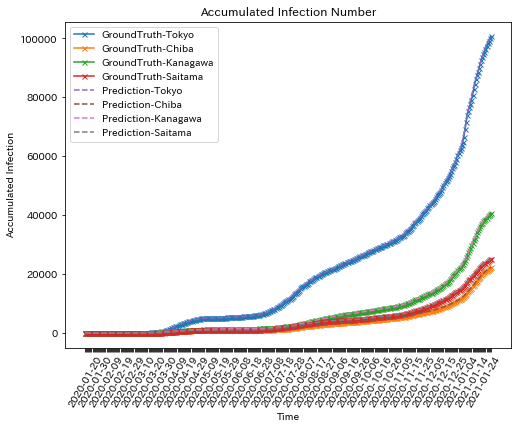

In [6]:
labels = []
labels.extend(['GroundTruth-' + pref for pref in TARGET_AREA_EN])
labels.extend(['Prediction-' + pref for pref in TARGET_AREA_EN])

plt.figure(figsize =(8, 6)) 
plt.plot(train_infection, markersize=5, marker ='x', linewidth=1.5)
plt.plot(predictions, linestyle='dashed', linewidth=1.5)
plt.legend(loc="upper left", labels=labels)
plt.title("Accumulated Infection Number", fontsize=12, y=1)
ticks = [date.strftime('%Y-%m-%d') for date in pd.date_range(start=START_DATE, end=END_DATE, freq='1D')]
ticks = [ticks[i] if i%10==0 else '' for i in range(len(ticks))]
plt.xticks(np.arange(train_infection.shape[0]), ticks, rotation=60)
plt.xlabel('Time')
plt.ylabel('Accumulated Infection')

In [7]:
def metric(prediction, ground_truth):
    RMSE = np.sqrt(np.mean((prediction-ground_truth)**2))
    MAE = np.mean(np.abs(prediction-ground_truth))
    MAPE = np.mean(np.abs(prediction-ground_truth)/ground_truth)
    return RMSE, MAE, MAPE

def predict(trans, infec):
    betas = np.loadtxt(BASE + '/{}_betas_{}days.csv'.format(NAME, T_INTERVAL), delimiter=',')
    beta = betas[-1, :]
    df_seir = pd.read_csv(BASE + '/{}_lastseir_{}days.csv'.format(NAME, T_INTERVAL), index_col=0)
    _, prediction = SEIR_Multi(beta, np.arange(len(trans)), df_seir, trans)
    np.savetxt(BASE + '/{}_prediction_real_20210201to20210228.csv'.format(NAME), prediction, delimiter=',', fmt='%d')
    print('trans, infections, predictions...', trans.shape, infec.shape, prediction.shape)
    print('RMSE, MAE, MAPE', metric(prediction, infec))
    return prediction

prediction_real = predict(trans=test_trans, infec=test_infection)

trans, infections, predictions... (28, 4, 4) (28, 4) (28, 4)
RMSE, MAE, MAPE (1339.8774364257565, 980.9196428571429, 0.023582084703837762)


In [21]:
pred_trans = np.squeeze(np.load('data/Feb_OD_prediction.npy'))[:, :, :]
pred_trans = pred_trans[:, TARGET_AREA_ID, :][:, :, TARGET_AREA_ID]
prediction_real = predict(trans=pred_trans, infec=test_infection)

trans, infections, predictions... (28, 4, 4) (28, 4) (28, 4)
RMSE, MAE, MAPE (1343.437820880233, 988.9107142857143, 0.027639063045901698)


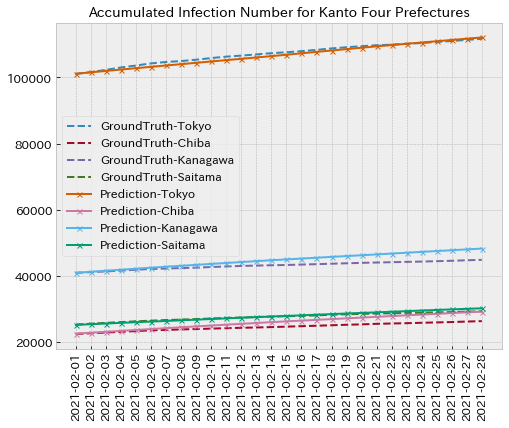

In [22]:
labels = []
labels.extend(['GroundTruth-' + pref for pref in TARGET_AREA_EN])
labels.extend(['Prediction-' + pref for pref in TARGET_AREA_EN])

with plt.style.context('bmh'):
    plt.figure(figsize =(8, 6)) 
    plt.plot(test_infection, linestyle='dashed', linewidth=2)
    plt.plot(prediction_real, linewidth=2, marker='x', markersize=5)
    plt.legend(loc="best", labels=labels, fontsize=12)
    plt.tick_params(labelsize=12)
    plt.title("Accumulated Infection Number for Kanto Four Prefectures", fontsize=14, y=1)
    ticks = [date.strftime('%Y-%m-%d') for date in pd.date_range(start=PRED_START_DATE, end=PRED_END_DATE, freq='1D')]
    # ticks = [ticks[i] if i%10==0 else '' for i in range(len(ticks))]
    plt.xticks(np.arange(len(ticks)), ticks, rotation=90)

(406, 4) (406, 4)


Text(0, 0.5, 'Accumulated Infection')

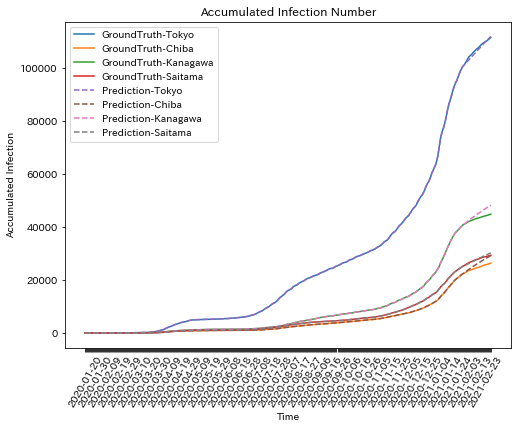

In [10]:
infection_tmp = np.concatenate((train_infection, test_infection), axis=0)
prediction_tmp = np.concatenate((train_infection, prediction_real), axis=0)
print(infection_tmp.shape, prediction_tmp.shape)

labels = []
labels.extend(['GroundTruth-' + pref for pref in TARGET_AREA_EN])
labels.extend(['Prediction-' + pref for pref in TARGET_AREA_EN])

plt.figure(figsize =(8, 6)) 
plt.plot(infection_tmp, linewidth=1.5)
plt.plot(prediction_tmp, linestyle='dashed', linewidth=1.5)
plt.legend(loc="upper left", labels=labels)
plt.title("Accumulated Infection Number", fontsize=12, y=1)
ticks = [date.strftime('%Y-%m-%d') for date in pd.date_range(start=START_DATE, end=PRED_END_DATE, freq='1D')]
ticks = [ticks[i] if i%10==0 else '' for i in range(len(ticks))]
plt.xticks(np.arange(infection_tmp.shape[0]), ticks, rotation=60)
plt.xlabel('Time')
plt.ylabel('Accumulated Infection')